<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dateset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [2]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [3]:
# zichtop sample
df_zichtop.head(200)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
0,5611,2021-01-01 00:00:00,830,136.0,80.0,34.0,57.0,34.0,34.0,455.0
1,5611,2021-01-01 01:00:00,837,138.0,11.0,23.0,92.0,23.0,80.0,470.0
2,5611,2021-01-01 02:00:00,745,41.0,0.0,0.0,82.0,51.0,71.0,500.0
3,5611,2021-01-01 03:00:00,876,115.0,0.0,0.0,52.0,21.0,125.0,563.0
4,5611,2021-01-01 04:00:00,714,49.0,0.0,0.0,37.0,25.0,111.0,492.0
...,...,...,...,...,...,...,...,...,...,...
195,5611,2021-01-09 03:00:00,652,56.0,0.0,0.0,0.0,34.0,34.0,528.0
196,5611,2021-01-09 04:00:00,592,41.0,0.0,0.0,0.0,14.0,28.0,509.0
197,5611,2021-01-09 05:00:00,739,25.0,13.0,0.0,0.0,38.0,75.0,588.0
198,5611,2021-01-09 06:00:00,906,38.0,13.0,0.0,38.0,102.0,115.0,600.0


In [4]:
# air_pollution sample
df_air_pollution.sample(5)

,date,PC4,pm10,pm2.5,no2,no,so2
24614,2021-10-15 14:00:00,5629,9.265925,3.082743,10.400822,6.804793,0.295102
74257,2021-12-27 00:00:00,5651,29.576550,58.405690,35.672718,3.944973,0.883436
34630,2021-10-30 22:00:00,5643,7.619550,4.410367,15.306439,10.014319,1.430633
33869,2021-09-29 05:00:00,5643,4.113281,3.089702,18.128669,11.860778,1.549491
64905,2021-12-15 08:00:00,5657,30.652600,58.773600,32.657959,4.619530,3.623938


<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [5]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [6]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [7]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [8]:
df_zichtop.describe()

,PC4,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
count,255024.000000,255024.000000,254276.000000,254276.000000,254276.00000,254276.000000,254276.000000,254276.000000,254276.000000
mean,5633.818182,1984.896131,334.580322,41.012966,73.50676,126.323121,237.291384,349.584455,827.626296
std,15.168687,1285.972747,376.307733,61.055502,104.01577,186.176472,331.758108,380.206726,538.795020
min,5611.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-3.000000
25%,5622.000000,1060.000000,56.000000,0.000000,0.00000,9.000000,38.000000,98.000000,471.000000
50%,5631.000000,1703.000000,222.000000,15.000000,32.00000,62.000000,119.000000,236.000000,781.000000
75%,5646.000000,2615.000000,481.000000,60.000000,107.00000,173.000000,292.000000,454.000000,1093.000000
max,5658.000000,11617.000000,4885.000000,2090.000000,1564.00000,5326.000000,3515.000000,3368.000000,3409.000000


<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [9]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,pm2.5
10483,5621,2021-11-15 19:00:00,1509,265.0,28.0,56.0,126.0,56.0,279.0,699.0,20.946737
38614,5655,2021-10-08 22:00:00,1624,64.0,0.0,0.0,32.0,127.0,96.0,1305.0,10.834876
18277,5627,2021-11-10 13:00:00,4577,524.0,95.0,183.0,318.0,1295.0,787.0,1375.0,18.623011
33520,5651,2021-10-16 16:00:00,3697,1239.0,63.0,147.0,315.0,777.0,420.0,736.0,9.276691
30145,5644,2021-11-10 01:00:00,950,26.0,0.0,0.0,9.0,0.0,0.0,915.0,22.372599


In [10]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [11]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
3812,5613,2021-11-12 20:00:00,2746,11.013641,750.0,290.0,218.0,375.0,302.0,230.0,581.0
735,5611,2021-10-25 15:00:00,6742,7.098761,1180.0,337.0,303.0,876.0,1433.0,1551.0,1062.0
41388,5657,2021-10-14 12:00:00,5574,14.410708,1298.0,183.0,290.0,565.0,1542.0,1527.0,169.0
19110,5628,2021-10-21 06:00:00,4378,1.581484,1019.0,14.0,72.0,115.0,1191.0,804.0,1163.0
35855,5653,2021-10-03 23:00:00,1473,1.302050,57.0,0.0,0.0,43.0,43.0,86.0,1244.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [12]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [13]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [14]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
41583,5657,2021-10-22 15:00:00,4430,2.671429,1978.0,172.0,129.0,301.0,559.0,1140.0,151.0,2021-10-22,15:00:00
7495,5616,2021-11-01 07:00:00,4465,7.107236,490.0,38.0,38.0,254.0,1714.0,980.0,951.0,2021-11-01,07:00:00
13001,5623,2021-11-10 17:00:00,3162,49.324093,373.0,75.0,160.0,256.0,319.0,1001.0,978.0,2021-11-10,17:00:00
7685,5616,2021-11-09 05:00:00,1979,15.587507,68.0,11.0,23.0,23.0,45.0,271.0,1538.0,2021-11-09,05:00:00
11569,5622,2021-11-06 01:00:00,946,7.127621,21.0,0.0,0.0,0.0,21.0,32.0,872.0,2021-11-06,01:00:00


<h4><font color=mediumvioletred>Get number of people in zipcode 5611 on 2021-09-25 </font></h4>

In [15]:
people_5611 = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]

<h4><font color=mediumvioletred>Visualize number of people in zipcode 5611 on 2021-09-25 </font></h4>

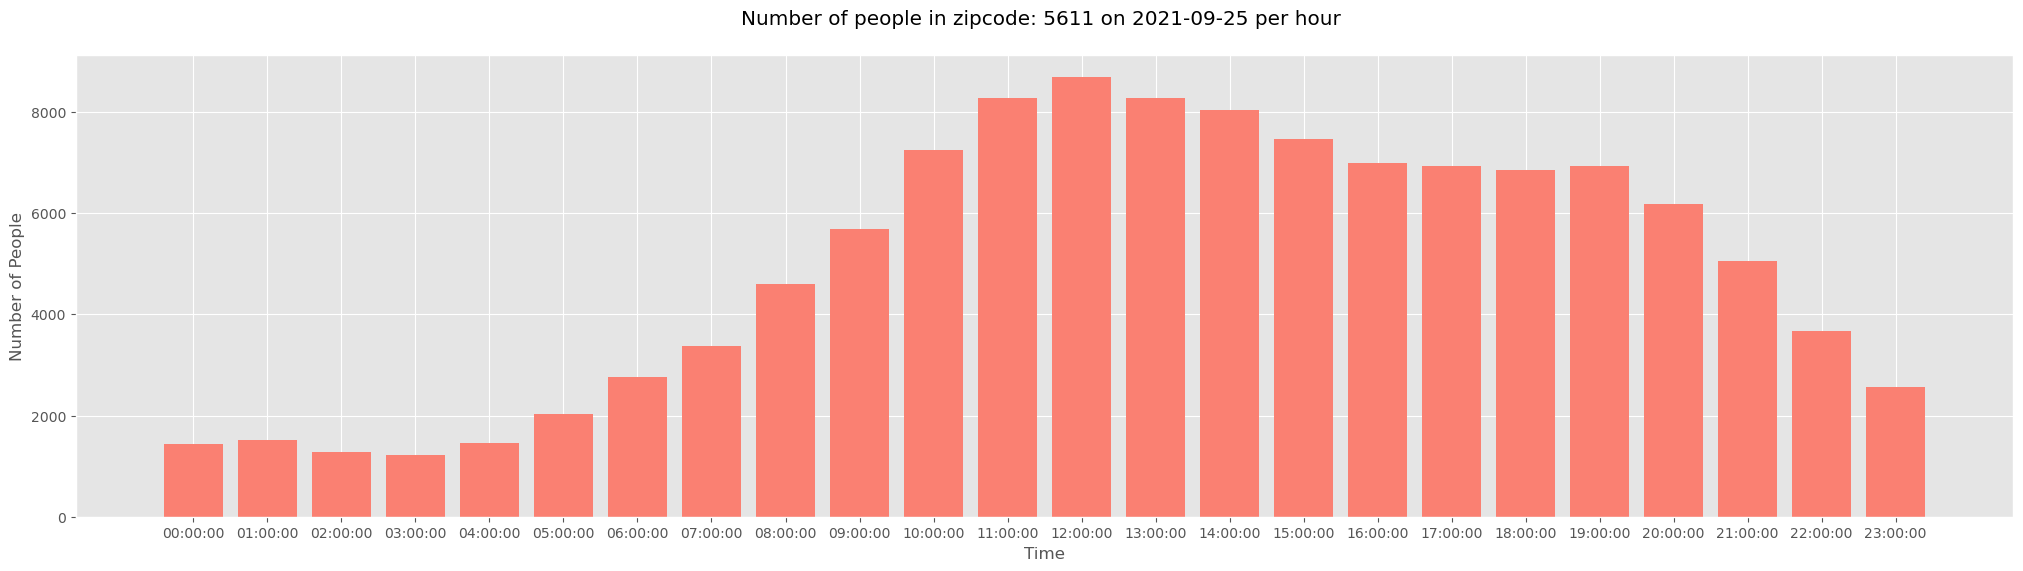

In [16]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
scatter = ax.bar(list(people_5611["time"]),
                list(people_5611["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zipcode: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

<h4><font color=mediumvioletred> Get maximum number of people per zipcode </font></h4>

In [25]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

,PC4,pop_tot
0,5611,11617
1,5612,10250
2,5613,5925
3,5614,3504
4,5615,4408


<h4><font color=mediumvioletred> Visualize maximum number of people per zipcode </font></h4>

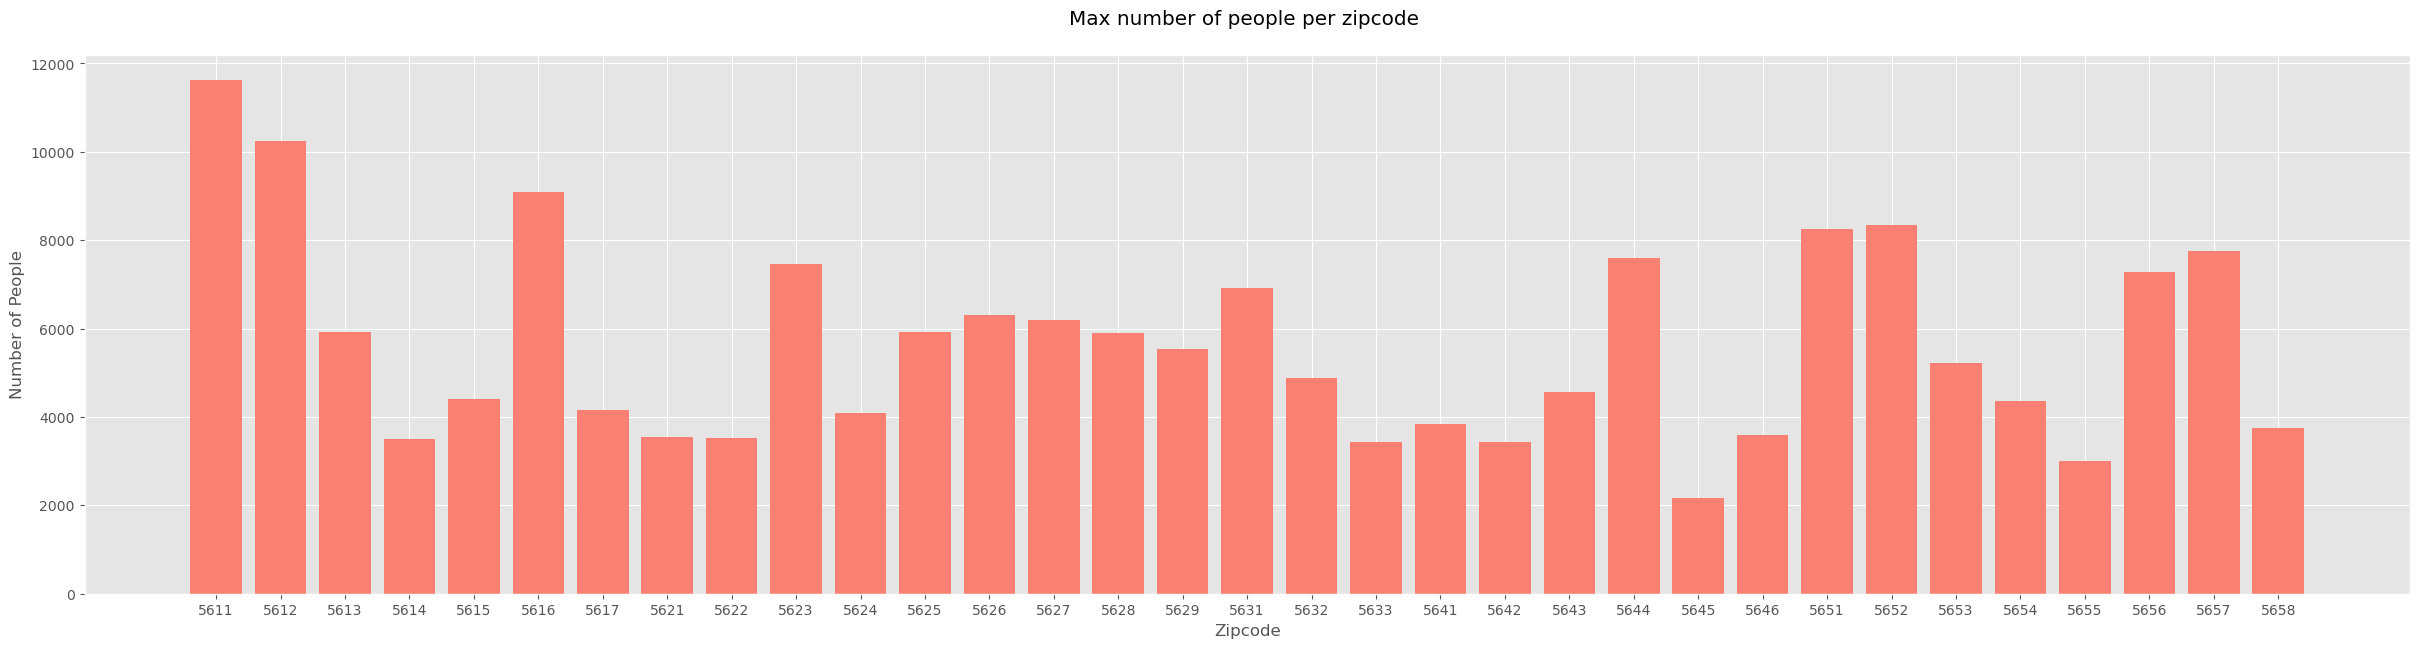

In [18]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
scatter = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zipcode \n",
      xlabel="Zipcode",
      ylabel="Number of People");

Zipcodes 5611, 5612, 5616 have the highest number of people.

<h4><font color=mediumvioletred> Get maximum and minimum number of people per zipcode </font></h4>

In [19]:
max_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min"]).reset_index()
max_min_people.head()

,PC4,max,min
0,5611,11617,708
1,5612,10250,737
2,5613,5925,537
3,5614,3504,217
4,5615,4408,394


<h4><font color=mediumvioletred> Visualize maximum and minimum number of people per zipcode </font></h4>

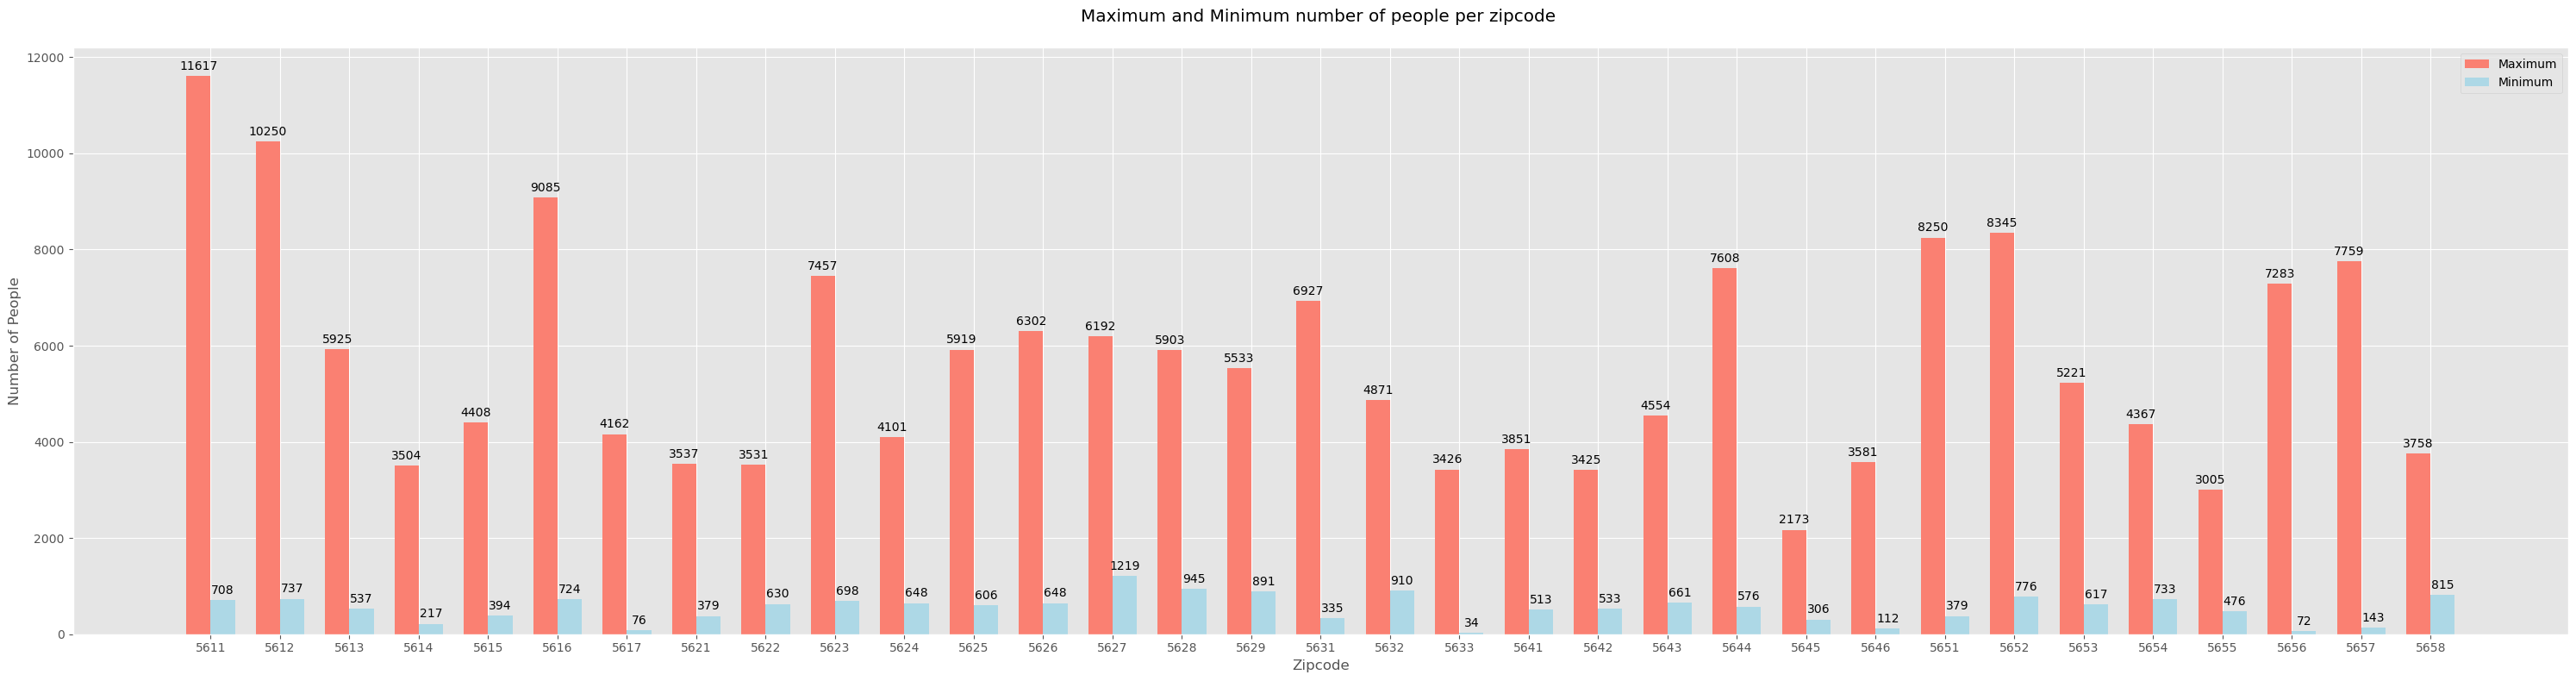

In [21]:
fig, ax = plt.subplots(figsize=(30, 8))

x = np.arange(len(max_min_people["PC4"]))  # the label locations
width = 0.35  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width/2, max_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x + width/2, max_min_people["min"], width, label="Minimum", color="lightblue")

# Customize the plot
ax.set_ylabel("Number of People")
ax.set_xlabel("Zipcode")
ax.set_title("Maximum and Minimum number of people per zipcode \n")
ax.set_xticks(x, max_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Zipcodes 5611, 5612, 5616 have the highest number of people and zipcodes 5633, 5656, 5617 have the lowest number of people.

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>